In [1]:
import os 
import pickle
import tempfile
import wget
import zipfile
from collections import Counter
from pathlib import Path
from typing import Tuple

import numpy as np
import pandas as pd
from tqdm import trange

from dotmap import DotMap
import random
import math

Below are the list of arguments and parameters used in the process of loading and preprocessing the dataset. Feel free to alter the values according to your experiment.

In [49]:
args = DotMap()

args.dataset_root = Path('/ssd003/projects/aieng/public/recsys_datasets/kasandr/de')
args.preprocessed = Path(f'./Data/kasandr/preprocessed')
args.min_uc = 5
args.max_uc = 1000
args.min_mc = 5
args.min_us_prod_types = 2

args.eval_set_size = 500

args.train_batch_size = 128
args.val_batch_size = 128
args.test_batch_size = 128

args.negative_sample_size = 30

args.data_seed = 98765

args.user_sample = 0.2

In [3]:
DATA_PATH = "/ssd003/projects/aieng/public/recsys_datasets/kasandr/de"

train_path = os.path.join(DATA_PATH, r'train_de.csv')
test_path = os.path.join(DATA_PATH, r'test_de.csv')

df = pd.read_csv(train_path, delimiter = '\t')


In [4]:
# user_list = list(set(df['userid']))
# sampled_users = random.sample(user_list, math.floor(len(user_list)*args.user_sample))
# df = df[df['userid'].isin(sampled_users)]

df = df[df['rating'] == 1]

In [5]:
df

,userid,offerid,countrycode,category,merchant,utcdate,rating
44,5bafdc0592dff7fa8c2898888d7fa183865a8a425d15f8...,b24526a20f4e4412d9301c328ff71f61,de,138001,9f6c66333880924b1d7db5d2903ee94f8c1d8d958d3afb...,2016-06-02 17:50:48.0,1
56,6eb2fe43a01f9daf19af5873cbc279c07dffb10790da96...,2bfd670e616b8f088797487eb6b71515,de,100354123,ab8863ef55e574c0093451ca02bc1842bd88e0fc32cf67...,2016-06-02 17:51:20.0,1
80,7c61831be004421505903f990a5b4f597322307e572a39...,05aa287e0a53f6a5c9b92a273ded0844,de,100091613,418899436d9314d6afe780b7fad289efed5115928e9329...,2016-06-02 17:53:50.0,1
93,7735de9a62b5bdd4307818b3fa7928ec226ac1f8607831...,9674edeb73f6e51ade9481ad452edcb4,de,142101,c26503aa822d9652cb0c2274a76467c5720e341e549d7c...,2016-06-02 17:54:47.0,1
107,2014a976a7e6775f784952118aba4cbdef790c5608bc53...,9157b97ae21f55ed3fe7e63e79c711c5,de,164401,b042951fdb45ddef8ba6075ced0e5885bc2fa4c4470bf7...,2016-06-02 17:55:45.0,1
...,...,...,...,...,...,...,...
15844610,fd82bceb96006341c7b56ca561d8496c624235d7f48f3f...,0f2fcf95319f5c1e5745371351f521e5,de,125801,a7b2f269064dbe77eb21b5a8b0f067d3f297a26aa185d3...,2016-06-14 20:08:53.0,1
15844613,2413e7ee24872c11cf72737e8abd99ae8b90e12f110e67...,ebb77a97cfdfd01c8b2f5cbffb1d5627,de,100020213,ac26975cf46eae9898b7d906bdfbbf99ce7813ffc3f9b7...,2016-06-14 20:09:19.0,1
15844616,860ca92277a6b738fa2642157cbaf26e8ad201249d17a7...,0f2fcf95319f5c1e5745371351f521e5,de,125801,a7b2f269064dbe77eb21b5a8b0f067d3f297a26aa185d3...,2016-06-14 20:09:33.0,1
15844617,001fecc308b147cbd9837051c62f035fd75ab42b3ef19c...,0f2fcf95319f5c1e5745371351f521e5,de,125801,a7b2f269064dbe77eb21b5a8b0f067d3f297a26aa185d3...,2016-06-14 20:09:52.0,1


<AxesSubplot:ylabel='Frequency'>

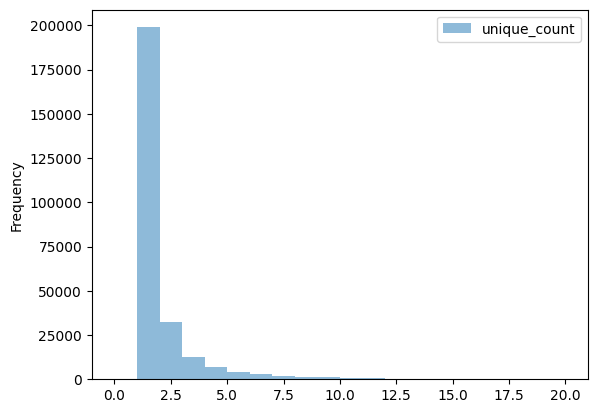

In [40]:
group_count = df.groupby('userid')['offerid'].agg(unique_count='nunique').reset_index()
group_count.plot.hist(bins=20, alpha=0.5, range=[0, 20])

#### Most users only have history with one unique offer, in order to fairly measure the performance of the recommender we will drop those records

## Data Preprocessing

The goal of data preprocessing is to make the dataset compatible with BERT4Rec. The preprocessing steps are based on the Pytorch implementation of BERT4Rec provided [here](https://github.com/jaywonchung/BERT4Rec-VAE-Pytorch).

The first step of preprocessing is to filter the data based on 
1. Rating values: removing the records with a rating lower than `args.min_rating`.
2. Number of ratings per movie: removing the movies that have been rated fewer times than `args.min_mc`.
3. Number of ratings per user: removing the users who have rated movies fewer times than `args.min_uc`.

In [53]:
def filter_min_mc(df):
    """removes the movie records that have been rated less frequent than minimun

    Args:
        df (pd.Dataframe): a pandas dataframe including uid, sid, rating, timestamp, 
        title, and genre)

    Returns:
        df (pd.Dataframe): the updated dataframe
    """
    if args.min_mc > 0:
            item_sizes = df.groupby('offerid').size()
            good_items = item_sizes.index[item_sizes >= args.min_mc]
            df = df[df['offerid'].isin(good_items)]
    return df

def filter_min_uc(df):
    """removes the user records that have rated less frequent than minimun

    Args:
        df (pd.Dataframe): a pandas dataframe including uid, sid, rating, timestamp, 
        title, and genre)

    Returns:
        df (pd.Dataframe): the updated dataframe
    """
    if args.min_uc > 0:
            user_sizes = df.groupby('userid').size()
            good_users = user_sizes.index[user_sizes >= args.min_uc]
            df = df[df['userid'].isin(good_users)]
    return df

def filter_max_uc(df):
    """removes the user records that have too many records

    Args:
        df (pd.Dataframe): a pandas dataframe including uid, sid, rating, timestamp, 
        title, and genre)

    Returns:
        df (pd.Dataframe): the updated dataframe
    """
    if args.max_uc > 0:
            user_sizes = df.groupby('userid').size()
            good_users = user_sizes.index[user_sizes <= args.max_uc]
            df = df[df['userid'].isin(good_users)]
    return df

def filter_min_user_product_types(df):
    """removes the user records only have records with one single product

    Args:
        df (pd.Dataframe): a pandas dataframe including uid, sid, rating, timestamp, 
        title, and genre)

    Returns:
        df (pd.Dataframe): the updated dataframe
    """
    if args.min_us_prod_types > 0:
            user_num_products = df.groupby('userid')['offerid'].agg(unique_count='nunique').reset_index()
            
            good_users = user_num_products[user_num_products['unique_count'] >= args.min_us_prod_types]['userid']
            df = df[df['userid'].isin(good_users)]
    return df

In [54]:
df2 = df.copy()

df2 = filter_min_mc(df2)
df2 = filter_min_uc(df2)
df2 = filter_max_uc(df2)
df2 = filter_min_user_product_types(df2)


In [55]:
df2

,userid,offerid,countrycode,category,merchant,utcdate,rating
56,6eb2fe43a01f9daf19af5873cbc279c07dffb10790da96...,2bfd670e616b8f088797487eb6b71515,de,100354123,ab8863ef55e574c0093451ca02bc1842bd88e0fc32cf67...,2016-06-02 17:51:20.0,1
254,3bdebd35724d8857f2d7624312d3924314a4ae4d5f4e96...,d795543742a6e7ef883d56f032d12ad2,de,100020213,c585a21209976b2c47f5a83acec799c948cd4d624ccb1d...,2016-06-02 18:08:53.0,1
319,291d7fcd5af5921e7163e545a042492a20aaa218605884...,6143a53c617d3725a93ce020c94be9e9,de,168001,00a3853a20be77f841a0c1432cdfb97bf85b4b1d89dd85...,2016-06-02 18:15:01.0,1
325,44bd668289c6bf71447df61c0a354c6a49fe6ad1548e11...,9d9f5e979f8b2ee1b9810e2a7aaa1be8,de,100232023,a7562c31346023a52a2d2f74ac432a127c7acff0d73535...,2016-06-02 18:15:43.0,1
1114,9734d214f2c02ff766e9a1fa139a9e9ed1cd60f0881c65...,0f2fcf95319f5c1e5745371351f521e5,de,125801,a7b2f269064dbe77eb21b5a8b0f067d3f297a26aa185d3...,2016-06-14 16:23:21.0,1
...,...,...,...,...,...,...,...
15844605,a78d0d8a20679587d81e92f75a3ea0d421758d18b384e2...,ebb77a97cfdfd01c8b2f5cbffb1d5627,de,100020213,ac26975cf46eae9898b7d906bdfbbf99ce7813ffc3f9b7...,2016-06-14 20:08:35.0,1
15844607,001fecc308b147cbd9837051c62f035fd75ab42b3ef19c...,0f2fcf95319f5c1e5745371351f521e5,de,125801,a7b2f269064dbe77eb21b5a8b0f067d3f297a26aa185d3...,2016-06-14 20:08:38.0,1
15844613,2413e7ee24872c11cf72737e8abd99ae8b90e12f110e67...,ebb77a97cfdfd01c8b2f5cbffb1d5627,de,100020213,ac26975cf46eae9898b7d906bdfbbf99ce7813ffc3f9b7...,2016-06-14 20:09:19.0,1
15844616,860ca92277a6b738fa2642157cbaf26e8ad201249d17a7...,0f2fcf95319f5c1e5745371351f521e5,de,125801,a7b2f269064dbe77eb21b5a8b0f067d3f297a26aa185d3...,2016-06-14 20:09:33.0,1


After filtering some of the records in the dataset, the movie ids and the user ids are densified so that there is no missing id value in the sequence of all ids.

In [56]:
# reassign userid and offerid to int range

def densify_index(df):
    """reassigns the user and movie ids to remove the gaps caused by deletions

    Args:
        df (pd.Dataframe): a pandas dataframe including uid, sid, rating, timestamp, 
        title, and genre)

    Returns:
        df (pd.Dataframe): the updated dataframe
    """
    umap = {u: i for i, u in enumerate(set(df['userid']))}
    smap = {s: i for i, s in enumerate(set(df['offerid']))}
    df['userid'] = df['userid'].map(umap)
    df['offerid'] = df['offerid'].map(smap)
    return df, umap, smap

In [57]:
df2, umap, smap = densify_index(df2)

df2

,userid,offerid,countrycode,category,merchant,utcdate,rating
56,2825,10696,de,100354123,ab8863ef55e574c0093451ca02bc1842bd88e0fc32cf67...,2016-06-02 17:51:20.0,1
254,4436,6476,de,100020213,c585a21209976b2c47f5a83acec799c948cd4d624ccb1d...,2016-06-02 18:08:53.0,1
319,4169,840,de,168001,00a3853a20be77f841a0c1432cdfb97bf85b4b1d89dd85...,2016-06-02 18:15:01.0,1
325,4197,1426,de,100232023,a7562c31346023a52a2d2f74ac432a127c7acff0d73535...,2016-06-02 18:15:43.0,1
1114,2787,5295,de,125801,a7b2f269064dbe77eb21b5a8b0f067d3f297a26aa185d3...,2016-06-14 16:23:21.0,1
...,...,...,...,...,...,...,...
15844605,5949,580,de,100020213,ac26975cf46eae9898b7d906bdfbbf99ce7813ffc3f9b7...,2016-06-14 20:08:35.0,1
15844607,1044,5295,de,125801,a7b2f269064dbe77eb21b5a8b0f067d3f297a26aa185d3...,2016-06-14 20:08:38.0,1
15844613,3837,580,de,100020213,ac26975cf46eae9898b7d906bdfbbf99ce7813ffc3f9b7...,2016-06-14 20:09:19.0,1
15844616,1671,5295,de,125801,a7b2f269064dbe77eb21b5a8b0f067d3f297a26aa185d3...,2016-06-14 20:09:33.0,1


Finally the dataset is split into three subsets for training, validation, and testing. Since BERT4Rec adopts leave-one-out evaluation method, the dataset is split in a way that for each user, the last item of the rating sequence is held as the test data, the item just before the last is held as the validation set, and the remaining items are used for training.

In [58]:
def split_df(df, user_count):
    """splits dataset to train, validation, and test sets

    Args:
        df (pd.Dataframe): the preprocessed dataframe
        user_count (int): number of all users in the dataset

    Returns:
        Tuple: a tuple of data splits
    """
    user_group = df.groupby('userid')
    user2items = user_group.apply(lambda d: list(d.sort_values(by='utcdate')['offerid']))
    user2labels = user_group.apply(lambda d: list(d.sort_values(by='utcdate')['rating']))    
    
    train, val, test, val_label, test_label = {}, {}, {}, {}, {}
    for user in range(user_count):
        items = user2items[user]
        labels = user2labels[user]
        train[user], val[user], test[user] = items[:-2], items[-2:-1], items[-1:]
        val_label[user], test_label[user] = labels[-2:-1], labels[-1:]
    return train, val, test, val_label, test_label

def filter_train(df, train, user_count):
    """
    keep 1 labelled items from train dataset
    """
    train_filtered = {}
    df = df.sort_values('utcdate')
    
    for user in range(user_count):
        df_user_items = df[df['userid'] == user]
        df_user_items = df_user_items.iloc[:-2]
        df_user_items = df_user_items[df_user_items['rating'] == 1]
        train_filtered[user] = list(df_user_items['offerid'])

    return train_filtered

All the preprocessing functions are applied to the data as below, and the final dataframe and the data splits are stored in the `preprocessed` directory.

In [59]:
# df = filter_min_mc(df)
# df = filter_min_uc(df)
# df, umap, smap = densify_index(df)

user_count = len(umap)
item_count = len(smap)

train, val, test, val_label, test_label = split_df(df2, user_count)

dataset = {'train': train,
            'val': val,
            'test': test,
            'val_label': val_label,
            'test_label': test_label,
            'umap': umap,
            'smap': smap}

# temp_train = filter_train(df2, train, user_count)
# temp_train

dataset_path = args.preprocessed.joinpath('dataset.pkl')
with dataset_path.open('wb') as f:
    pickle.dump(dataset, f)

df_path = args.preprocessed.joinpath('preprocessed.csv')
df.to_csv(df_path, index=False)


In [60]:
len(train)

6056

To see how the data is split, let's take a look at the ratings by user 0 that are sorted based on the timestamp, and then see which partitions of the sequence are included in the train, validation, and test sets.

In [61]:
df2[df2['userid'].isin([0])].sort_values('utcdate')

,userid,offerid,countrycode,category,merchant,utcdate,rating
4289528,0,6519,de,145801,4caa35f6bf4466db696fabf2f20617bd45fdfc55c554e8...,2016-06-01 13:41:54.0,1
4059319,0,5570,de,100283023,c3fe7603909bd5fb5e1905132462d95e076128200e120f...,2016-06-03 11:53:09.0,1
1060193,0,1877,de,133501,f863d8b007f66d43cb920455e7408e217dcd05dbae6b10...,2016-06-03 23:37:58.0,1
6856488,0,5226,de,100332323,c95640f1717a78cd26c44a09ba516893dd8960f9401ecf...,2016-06-07 12:39:16.0,1
7908197,0,3660,de,100332323,c95640f1717a78cd26c44a09ba516893dd8960f9401ecf...,2016-06-07 20:57:45.0,1
13018760,0,10672,de,100356623,cecc89ae4ce31cd914582ca40fcc56ba2eae1da20b0b93...,2016-06-10 21:04:21.0,1
3165278,0,4221,de,108101,8fb1fab99fe590d1020a4f2868922d2e0009b933c01260...,2016-06-14 12:06:38.0,1


The train data includes all the above ratings except the last two.

In [62]:
train[11]

[2631, 4649, 5844, 5110]

The last but one rating in used for validation.

In [63]:
val[11]

[9908]

The last rating is used as the test data.

In [64]:
test[11]

[1346]

## Negative Sampling

To evaluate BERT4Rec, each ground truth item in the validation and test sets is paired with a number of sampled negative items that the user has not interacted with. The evaluation mertrics are then calculated using these values.

Below two negative samplers are presented:
1. Negative sampling based on popularity: The popular items are those ones that are rated more frequently. In this case, the negative samples are selected from a sorted list of popular items that the user has not interacted with.
2. Random negative sampling: The items are randomly sampled.

In [65]:
def random_negative_samples(train, val, test, user_count, item_count):
    """generates negative samples randomly

    Args:
        train (dict): train dataset
        val (dict): validation dataset
        test (dict): test dataset
        user_count (int): total number of users
        item_count (int): total number of items

    Returns:
        dict: negatives samples for all users
    """
    np.random.seed(args.data_seed)
    negative_samples = {}
    print('Sampling negative items')
    for user in trange(user_count):
        seen = set(train[user])
        seen.update(val[user])
        seen.update(test[user])

        samples = []
        for _ in range(args.negative_sample_size):
            item = np.random.choice(item_count) + 1
            while item in seen or item in samples:
                item = np.random.choice(item_count) + 1
            samples.append(item)

        negative_samples[user] = samples

    negatives_path = args.preprocessed.joinpath('random_negatives.pkl')
    with negatives_path.open('wb') as f:
        pickle.dump(negative_samples, f)

    return negative_samples

In [66]:
neg_sample_test = random_negative_samples(train, val, test, user_count, item_count)

Sampling negative items


100%|██████████| 6056/6056 [00:02<00:00, 2622.98it/s]
